In [62]:
#%env PATH=/usr/local/cuda-11.5/bin:/usr/bin:$PATH
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
from pinns.prelude import *
from pinns.domain import Hypercube
from pinns.calc import laplace, divergence
from scipy.stats.qmc import Sobol
from pinns.model import mlp
from pinns.opt import train_nn
from pinns.integrate import integrate, midpoint, gauss2

import itertools
import numpy as np
import matplotlib.pyplot as plt
from jax.config import config


In [64]:
a = 1.
b = 1.
c = 1.
domain = Hypercube((-a / 2, -b / 2, -c / 2), (a / 2, b / 2, c / 2))
x_dom = array(Sobol(3, seed=0).random_base2(12))
x_dom = domain.transform(x_dom)
x_bnd = array(Sobol(2, seed=1).random_base2(10))
x_bnd = domain.transform_bnd(x_bnd)

In [65]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_result(sol, ax):
    plt.sca(ax)
    N = 200
    x = np.linspace(-a/2, a/2, N)
    z = np.linspace(-c/2, c/2, N)

    X = np.array([_x for _x in itertools.product(x, z)])
    _X = jnp.asarray(X)
    _X = jnp.insert(_X, array([2]), zeros((N * N, 1)), 1)
    phi = np.array(sol(_X))

    p = ax.contourf(x, z, phi.reshape(N, N).T, 20, cmap=plt.get_cmap("autumn"), alpha=0.5)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)


def plot_model(model, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        fig.subplots_adjust(wspace=0.4)
    plot_result(model, ax)


In [66]:
weights = array(Sobol(4, seed=12345).random_base2(11))
W_elm = (weights[:, :3] * 2 - 1)
b_elm = (weights[:, 3] * 2 - 1)

def unit_vec(x):
    return x / norm(x, axis=-1, keepdims=True)

m_const = lambda x: array([0., 0., 1.])

def m_flower(x):
    mx = 1 / a * x[..., 0] * x[..., 2]
    my = 1 / c * x[..., 1] * x[..., 2] + 1 / b ** 3 * x[..., 1] ** 3 * x[..., 2] ** 3
    mz = ones_like(my)
    mag = stack([mx, my, mz], axis=-1)
    return unit_vec(mag)

def m_vortex(x):
    x, y, z = x[..., 0], x[..., 1], x[..., 2]
    rc = 0.14
    r = sqrt(x ** 2 + y ** 2)
    k = r**2 / rc**2
    mx = - y / r * sqrt(1 - exp(-4*k))
    my = x / r * sqrt(1 - exp(-4*k))
    mz = exp(-2*k)
    mag = stack([mx, my, mz], axis=-1)
    return unit_vec(mag)


m = m_vortex
f = lambda x: -divergence(m)(x)
def l(x):
    # x, y, z = x
    # return -(x - a / 2) * (x + a / 2) * (y - b / 2) * (y + b / 2) * (z - c / 2) * (z + c / 2)
    return jnp.prod(maximum(1 - abs(x)**2 / 0.5**2, 0))

#n = lambda x: normalize(-grad(l)(x))

def n(x):
    x, y, z = x
    x1 = jnp.where(x == -a/2, -1., 0.)
    x2 = jnp.where(x == a/2, 1., 0.)
    nx = x1 + x2
    y1 = jnp.where(y == -b/2, -1., 0.)
    y2 = jnp.where(y == b/2, 1., 0.)
    ny = y1 + y2
    z1 = jnp.where(z == -c/2, -1., 0.)
    z2 = jnp.where(z == c/2, 1., 0.)
    nz = z1 + z2
    return array([nx, ny, nz])


h = lambda x: tanh(W_elm @ x + b_elm)
u = lambda x: l(x) * h(x)

def test_fun(x, x0, r):
    s = norm(x - x0, axis=-1) / r
    return where(
        s >= 1., 
        0, 
        1 - 6 * s ** 2 + 8 * s ** 3 - 3 * s ** 4
    )

In [67]:
from pinns.integrate import integrate_sphere, gauss5


def integrate_sample(x, r):
    def integrand(x, x0, r):
        return jacfwd(u)(x) @ grad(test_fun)(x, x0, r)
    return integrate_sphere(
        integrand, r, x, 2, x, r, method=gauss5
    )

@jit
def integrate_samples(x, radii):
    return vmap(integrate_sample)(x, radii)


def integrate_source(x, r):
    def integrand(x, x0, r):
        return f(x) * test_fun(x, x0, r)
    return integrate_sphere(
        integrand, r, x, 2, x, r, method=gauss5
    )

@jit
def integrate_sources(x, radii):
    return vmap(integrate_source)(x, radii)



In [68]:
rmax = 0.1
def test_fun_radius(x):
    rmin = jnp.min(0.5 - abs(x))
    return minimum(rmin, rmax)

radii = vmap(test_fun_radius)(x_dom)
idx = radii > 1e-5
x_dom = x_dom[idx]
radii = radii[idx]


In [69]:
from jaxopt.linear_solve import solve_normal_cg
A_elm = integrate_samples(x_dom, radii)
b_source = integrate_sources(x_dom, radii)
params_phi1 = solve_normal_cg(lambda x: A_elm @ x, b_source, init=zeros(A_elm.shape[-1],))
phi1 = lambda x: u(x) @ params_phi1

In [70]:
def phi2_solution(x, x_bnd):
    eps = 1e-12
    def g(y):
        return dot(m(y), n(y)) - dot(grad(phi1)(y), n(y))
    
    dist = vmap(lambda x: norm(x - x_bnd, axis=-1))(x)
    _g = vmap(g)(x_bnd)
    def kernel(dist):
        idx = dist > eps
        newton_kernel = where(idx, 1 / dist, 0.)
        N = jnp.count_nonzero(idx)
        return 6 / (4 * pi * N) * dot(newton_kernel, _g)

    return vmap(kernel)(dist)

In [71]:
_x_bnd = array(Sobol(2, seed=123).random_base2(14))
_x_bnd = domain.transform_bnd(_x_bnd)
phi_bnd = phi2_solution(x_bnd, _x_bnd)

In [72]:
from pinns.elm import elm

g2 = elm(x_bnd, phi_bnd, W_elm, b_elm, ridge=0.00001)


def integrate_bnd(x, r):
    def integrand(x, x0, r):
        return grad(g2)(x) @ grad(test_fun)(x, x0, r)
    return integrate_sphere(
        integrand, r, x, 2, x, r, method=gauss5
    )

@jit
def integrate_bnd_data(x, radii):
    return vmap(integrate_bnd)(x, radii)



b2 = integrate_bnd_data(x_dom, radii)


In [73]:
from jaxopt.linear_solve import solve_normal_cg

params_phi2 = solve_normal_cg(lambda x: A_elm @ x, -b2, init=zeros(A_elm.shape[-1],))

phi2 = lambda x: g2(x) + u(x) @ params_phi2
phi_nn = lambda x: phi1(x) + phi2(x)

In [74]:
def ed(model, x):
    Ms = 1.
    mag = vmap(m)(x)
    H = lambda x: -grad(model)(x)
    e = lambda x: dot(m(x), H(x)) 
    return -Ms * (a * b * c) / 2 * jnp.sum(vmap(e)(x)) / len(x)

In [75]:
print(f"{2.189e-02 - abs(ed(phi_nn, x_dom)):.4e}")

1.0009e-03


In [76]:
1.5785e-03

0.0015785

In [80]:
abs(ed(phi_nn, x_dom))

DeviceArray(0.02088907, dtype=float32)

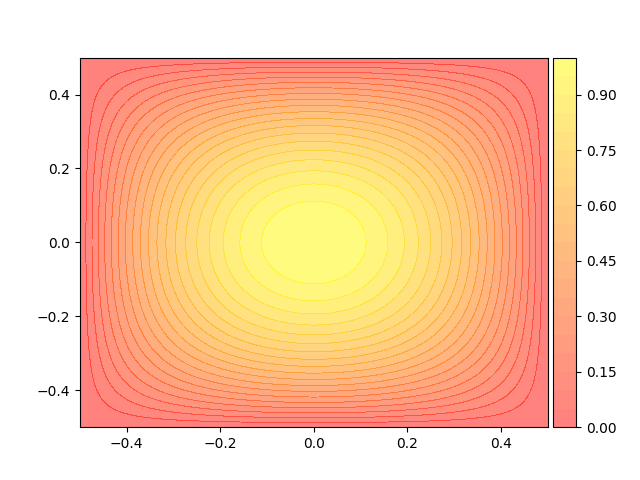

In [77]:
plot_model(vmap(l))

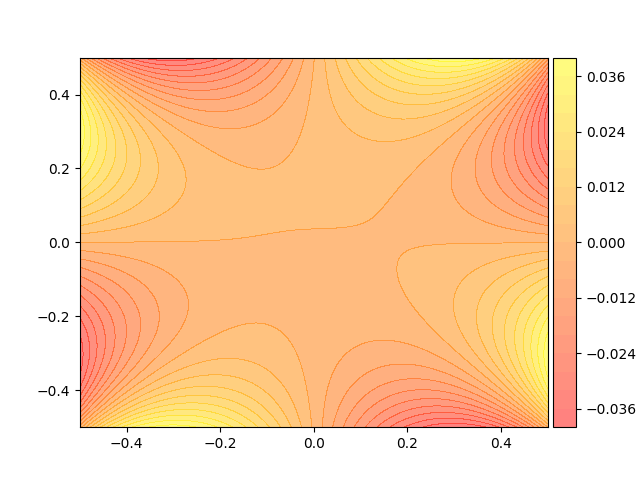

In [78]:
plot_model(vmap(phi_nn))

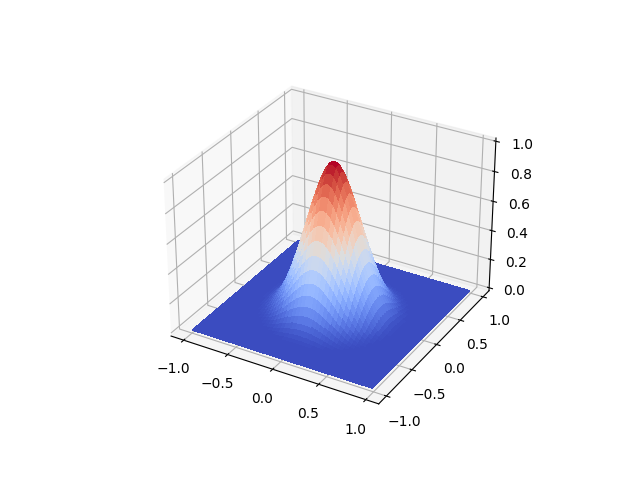

In [79]:
from matplotlib import cm

X = jnp.arange(-1, 1, 0.01)
Y = jnp.arange(-1, 1, 0.01)
X, Y = jnp.meshgrid(X, Y)


Z = test_fun(stack([X, Y], axis=-1), array([0, 0.]), 0.8)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
